# Reissner-Mindlin plates

```{admonition} Objectives
:class: objectives

This demo illustrates how to implement a Reissner-Mindlin thick plate model. The main specificity of such models is that one needs to solve for two different fields: a vertical deflection field $w$ and a rotation vector field $\boldsymbol{\theta}$.
$\newcommand{\bM}{\boldsymbol{M}}
\newcommand{\bQ}{\boldsymbol{Q}}
\newcommand{\bgamma}{\boldsymbol{\gamma}}
\newcommand{\btheta}{\boldsymbol{\theta}}
\newcommand{\bchi}{\boldsymbol{\chi}}
\renewcommand{\div}{\operatorname{div}}$
```


```{image} plate.svg
:width: 500px
:align: center
```

```{admonition} Download sources
:class: download

* {Download}`Python script<./plates.py>`
* {Download}`Jupyter notebook<./plates.ipynb>`
* {Download}`Complete sources files<./plates.zip>`
```


## Governing equations

We recall below the main relations defining this model in the linear elastic case.

### Generalized strains

* *Bending curvature* strain $\bchi = \dfrac{1}{2}(\nabla \btheta + \nabla^\text{T} \btheta) = \nabla^\text{s}\btheta$
* *Shear* strain $\bgamma = \nabla w - \btheta$

### Generalized stresses
* *Bending moment* $\bM$
* *Shear force* $\bQ$

### Equilibrium conditions
For a distributed transverse surface loading $f$,
* Vertical equilibrium: $\div \bQ + f = 0$
* Moment equilibrium: $\div \bM + \bQ = 0$

In weak form:

$$\int_{\Omega} (\bM:\nabla^\text{s}\widehat{\btheta} + \bQ\cdot(\nabla \widehat{w} - \widehat{\btheta}))\text{d}\Omega = \int_{\Omega} f w \text{d}\Omega \quad \forall \widehat{w},\widehat{\btheta}$$

### Isotropic linear elastic constitutive relation
* Bending/curvature relation:
\begin{align*}
\begin{Bmatrix}M_{xx}\\ M_{yy} \\M_{xy} \end{Bmatrix} &= \textsf{D} \begin{bmatrix}1 & \nu & 0 \\ \nu & 1 & 0 \\ 0 & 0 & (1-\nu)/2 \end{bmatrix}\begin{Bmatrix}\chi_{xx} \\ \chi_{yy} \\ 2\chi_{xy}  \end{Bmatrix}\\
\text{ where}\quad \textsf{D} &= \dfrac{E h^3}{12(1-\nu^2)}
\end{align*}

* Shear strain/stress relation:
\begin{align*}
\bQ &= \textsf{F}\bgamma\\
\text{ where}\quad \textsf{F} &= \dfrac{5}{6}\dfrac{E h}{2(1+\nu)}
\end{align*}


## Implementation

We first load relevant modules and functions and generate a unit square mesh of triangles.

In [5]:
import numpy as np
import ufl
import basix

from mpi4py import MPI
from dolfinx import fem, io
import dolfinx.fem.petsc
from dolfinx.mesh import (
    create_unit_square,
    CellType,
    DiagonalType,
    locate_entities_boundary,
)


N = 10
domain = create_unit_square(
    MPI.COMM_WORLD, N, N, cell_type=CellType.triangle, diagonal=DiagonalType.crossed
)

Next we define material properties and functions which will be used for defining the variational formulation.

In [6]:
# material parameters
thick = 0.05
E = 210.0e3
nu = 0.3

# bending stiffness
D = fem.Constant(domain, E * thick**3 / (1 - nu**2) / 12.0)
# shear stiffness
F = fem.Constant(domain, E / 2 / (1 + nu) * thick * 5.0 / 6.0)

# uniform transversal load
f = fem.Constant(domain, -100.0)


# Useful function for defining strains and stresses
def curvature(u):
    (w, theta) = ufl.split(u)
    return ufl.as_vector(
        [theta[0].dx(0), theta[1].dx(1), theta[0].dx(1) + theta[1].dx(0)]
    )


def shear_strain(u):
    (w, theta) = ufl.split(u)
    return theta - ufl.grad(w)


def bending_moment(u):
    DD = ufl.as_matrix([[D, nu * D, 0], [nu * D, D, 0], [0, 0, D * (1 - nu) / 2.0]])
    return ufl.dot(DD, curvature(u))


def shear_force(u):
    return F * shear_strain(u)

Now we define the corresponding function space. Our dofs are $w$ and $\btheta$, so the full function space $V$ will be a **mixed** function space consisting of a scalar subspace related to $w$ and a vectorial subspace related to $\btheta$. We first use a continuous $P^2$ interpolation for $w$ and a continuous $P^1$ interpolation for $\btheta$. We then define the corresponding linear and bilinear forms.

In [13]:
# Definition of function space for U:displacement, T:rotation
Ue = basix.ufl.element("P", domain.basix_cell(), 2)
Te = basix.ufl.element("P", domain.basix_cell(), 1, shape=(2,))
V = fem.functionspace(domain, basix.ufl.mixed_element([Ue, Te]))

# Functions
u = fem.Function(V, name="Unknown")
u_ = ufl.TestFunction(V)
(w_, theta_) = ufl.split(u_)
du = ufl.TrialFunction(V)

# Linear and bilinear forms
dx = ufl.Measure("dx", domain=domain)
L = f * w_ * dx
a = (
    ufl.dot(bending_moment(u_), curvature(du))
    + ufl.dot(shear_force(u_), shear_strain(du))
) * dx

Boundary conditions are now defined. We consider a fully clamped boundary. Note that since we are using a mixed function space, we cannnot use the `locate_dofs_geometrical` function. Instead, we locate the facets on the boundary using `dolfinx.mesh.locate_entities_boundary`. Then we locate the dofs on such facets using `locate_dofs_topological`.

In [15]:
# Boundary of the plate
def border(x):
    return np.logical_or(
        np.logical_or(np.isclose(x[0], 0), np.isclose(x[0], 1)),
        np.logical_or(np.isclose(x[1], 0), np.isclose(x[1], 1)),
    )


facet_dim = 1
clamped_facets = locate_entities_boundary(domain, facet_dim, border)
clamped_dofs = fem.locate_dofs_topological(V, facet_dim, clamped_facets)

u0 = fem.Function(V)
bcs = [fem.dirichletbc(u0, clamped_dofs)]

We now solve the problem and output the result. To get the deflection $w$, we use `u.sub(0).collapse()` to extract a new function living in the corresponding subspace. Note that `u.sub(0)` provides only an indexed view of the $w$ component of `u`. The computed results is compared with the analytical maximum deflection of a clamped Love-Kirchhoff plate:

$$
w_\text{LK} = 1.265319087.10^{-3} \dfrac{f}{\mathsf{D}}
$$

In [16]:
problem = fem.petsc.LinearProblem(
    a, L, u=u, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
problem.solve()

with io.VTKFile(domain.comm, "plates.xdmf", "w") as vtk:
    w = u.sub(0).collapse()
    w.name = "Deflection"
    vtk.write_function(w)

w_LK = 1.265319087e-3 * -f.value / D.value
print(f"Reissner-Mindlin deflection: {max(abs(w.vector.array)):.5f}")
print(f"Love-Kirchhoff deflection: {w_LK:.5f}")

Reissner-Mindlin deflection: 0.05380
Love-Kirchhoff deflection: 0.05264


```{warning}
This simple formulation may suffer from **shear locking** issues in the thin plate limit. We refer to the various plate tours dedicated to this specific issue for more accurate treatment of plate shear locking.
```

We can plot the plate deflection $w$ and the rotation vector $\boldsymbol{\beta} = \boldsymbol{e}_z\times \btheta$ using `pyvista`. $\boldsymbol{\beta}$ represents the axis vector around which the plate is rotating.

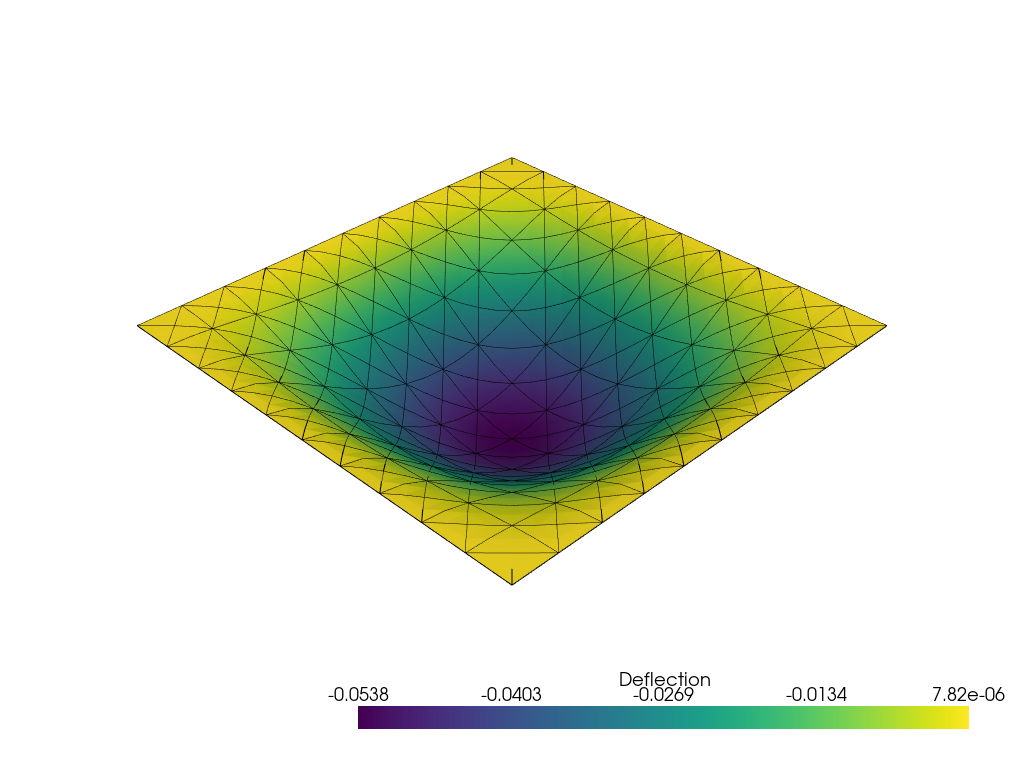

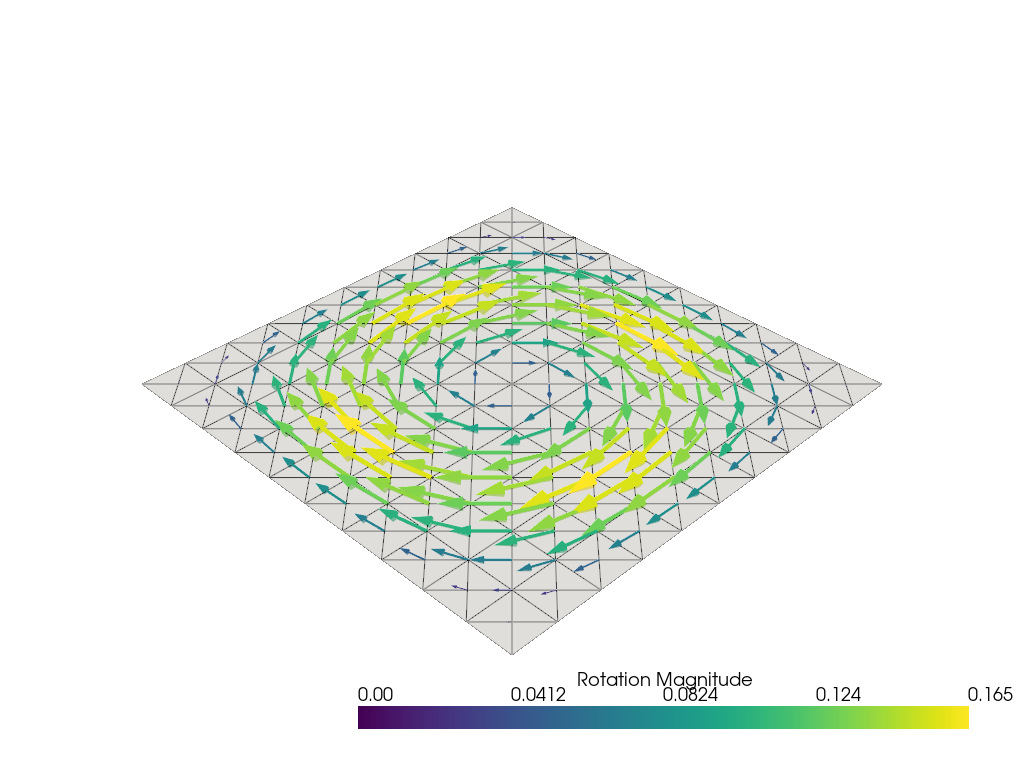

In [18]:
import pyvista
from dolfinx import plot

pyvista.set_jupyter_backend("static")

Vw = w.function_space
w_topology, w_cell_types, w_geometry = plot.vtk_mesh(Vw)
w_grid = pyvista.UnstructuredGrid(w_topology, w_cell_types, w_geometry)
w_grid.point_data["Deflection"] = w.x.array
w_grid.set_active_scalars("Deflection")
warped = w_grid.warp_by_scalar("Deflection", factor=5)

plotter = pyvista.Plotter()
plotter.add_mesh(
    warped,
    show_scalar_bar=True,
    scalars="Deflection",
)
edges = warped.extract_all_edges()
plotter.add_mesh(edges, color="k", line_width=1)
plotter.show()

theta = u.sub(1).collapse()
Vt = theta.function_space
theta_topology, theta_cell_types, theta_geometry = plot.vtk_mesh(Vt)
theta_grid = pyvista.UnstructuredGrid(theta_topology, theta_cell_types, theta_geometry)
beta_3D = np.zeros((theta_geometry.shape[0], 3))
beta_3D[:, :2] = theta.x.array.reshape(-1, 2) @ np.array([[0, -1], [1, 0]])
theta_grid["beta"] = beta_3D
theta_grid.set_active_vectors("beta")

plotter = pyvista.Plotter()
plotter.add_mesh(
    theta_grid.arrows, lighting=False, scalar_bar_args={"title": "Rotation Magnitude"}
)
plotter.add_mesh(theta_grid, color="grey", ambient=0.6, opacity=0.5, show_edges=True)
plotter.show()

## Modal analysis

Now we define the form corresponding to the definition of the mass matrix and we assemble the stiffness and mass forms into corresponding PETSc matrix objects. We use a value of 1 on the diagonal for K and 0 for M for the rows corresponding to the boundary conditions. Doing so, eigenvalues associated to boundary conditions are equal to infinity and will not pollute the low-frequency spectrum.

In [19]:
rho = fem.Constant(domain, 2700.0)
m_form = rho * thick * ufl.dot(du, u_) * dx

K = fem.petsc.assemble_matrix(fem.form(a), bcs, diagonal=1)
K.assemble()
M = fem.petsc.assemble_matrix(fem.form(m_form), bcs, diagonal=0)
M.assemble()

We now use `slepc4py` to define a eigenvalue solver (EPS -- *Eigenvalue Problem Solver* -- in SLEPc vocable) and solve the corresponding generalized eigenvalue problem. Functions defined in {Download}`eigenvalue_solver.py<./eigenvalue_solver.py>`
enable to define the corresponding objects, set up the parameters, monitor the resolution and extract the corresponding eigenpairs. Here the problem is of type `GHEP` (Generalized Hermitian eigenproblem) and we use a shift-invert transform to compute the smallest eigenvalues.

In [20]:
from slepc4py import SLEPc
from eigenvalue_solver import solve_GEP_shiftinvert, EPS_get_spectrum

N_eig = 6  # number of requested eigenvalues
eigensolver = solve_GEP_shiftinvert(
    K,
    M,
    problem_type=SLEPc.EPS.ProblemType.GHEP,
    solver=SLEPc.EPS.Type.KRYLOVSCHUR,
    nev=N_eig,
)
# Extract results
(eigval, eigvec_r, eigvec_i) = EPS_get_spectrum(eigensolver, V)
# Output eigenmodes
with io.VTKFile(domain.comm, "plates_eigenvalues.xdmf", "w") as vtk:
    for i in range(N_eig):
        w = eigvec_r[i].sub(0).collapse()
        w.name = "Deflection"
        vtk.write_function(w, i)

******************************
***  SLEPc Iterations...   ***
******************************
Iter. | Conv. | Max. error
    1 |     3 | 5.6e-06
    2 |     7 | 3.0e-07

******************************
*** SLEPc Solution Results ***
******************************
Iteration number: 2
Converged eigenpairs: 7

Converged eigval.  Error 
----------------- -------
 9.12e-01             2.1e-12
 1.67e+00             7.1e-10
 1.67e+00             6.7e-13
 2.34e+00             1.2e-09
 2.89e+00             2.8e-13
 3.15e+00             3.4e-13
 3.56e+00             4.7e-12


The eigenmodes look as follows using `pyvista`:

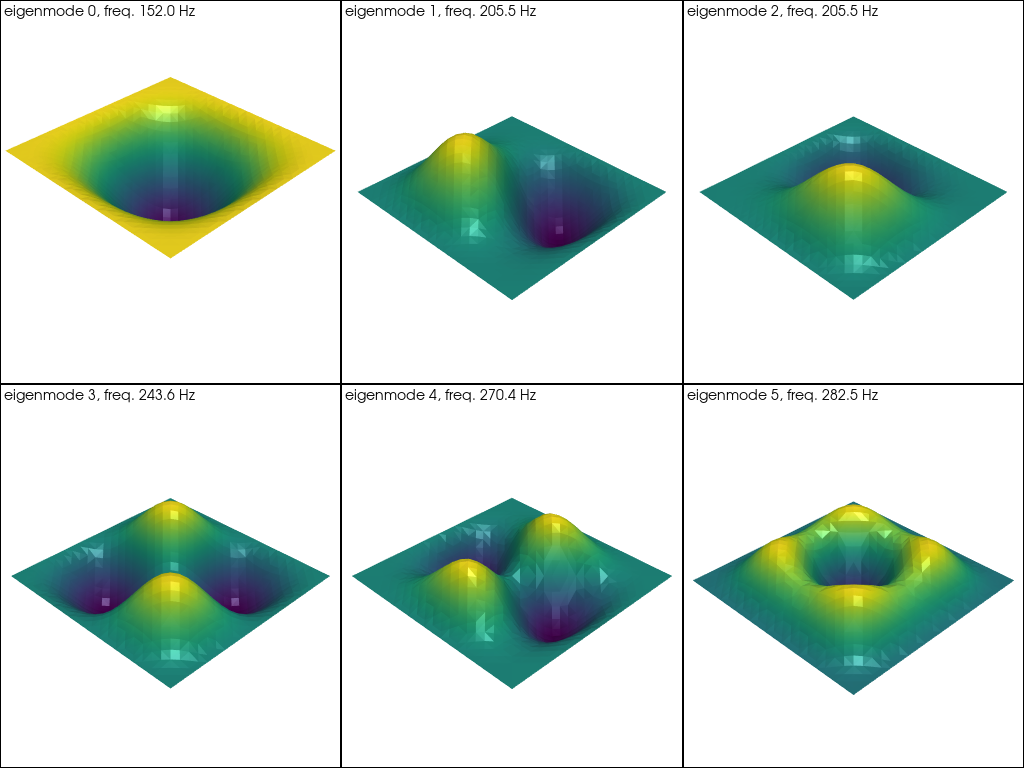

In [21]:
w_grid = pyvista.UnstructuredGrid(w_topology, w_cell_types, w_geometry)

pl = pyvista.Plotter(shape=(2, 3))
for i in range(2):
    for j in range(3):
        pl.subplot(i, j)
        current_index = 3 * i + j
        eigenmode = f"eigenmode_{current_index:02}"
        pl.add_text(
            f"eigenmode {current_index}, freq. {np.real(np.sqrt(eigval[current_index]))/2/np.pi*1e3:.1f} Hz",
            font_size=10,
        )
        wi = eigvec_r[current_index].sub(0).collapse()
        w_grid[eigenmode] = wi.x.array
        pl.add_mesh(
            w_grid.warp_by_scalar(eigenmode, factor=10.0),
            scalars=eigenmode,
            show_scalar_bar=False,
            specular=0.5,
            specular_power=30,
        )
pl.show()